# Regression on Sleep Data #

### Imports ###

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import time
import os
import glob
int_start = time.perf_counter()
plt.style.use('ggplot')

### Getting Data, Prelim Changes ###

In [70]:
path = 'csvs'
all_files = glob.glob(os.path.join(path, "*.csv"))

raw = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ISO8601         1395 non-null   object 
 1   fromDate        1395 non-null   object 
 2   toDate          1395 non-null   object 
 3   bedtime         1395 non-null   object 
 4   waketime        1395 non-null   object 
 5   inBed           1395 non-null   object 
 6   awake           1395 non-null   object 
 7   fellAsleepIn    1394 non-null   object 
 8   sessions        1395 non-null   int64  
 9   asleep          1395 non-null   object 
 10  asleepAvg7      1395 non-null   object 
 11  efficiency      1395 non-null   float64
 12  efficiencyAvg7  1395 non-null   float64
 13  quality         1394 non-null   object 
 14  qualityAvg7     1394 non-null   object 
 15  deep            1394 non-null   object 
 16  deepAvg7        1394 non-null   object 
 17  sleepBPM        1394 non-null   f

In [71]:
raw['fromDate'] = pd.to_datetime(raw['fromDate'])
raw['toDate'] = pd.to_datetime(raw['toDate'])
raw['bedtime'] = pd.to_datetime(raw['bedtime'])
raw['waketime'] = pd.to_datetime(raw['waketime'])
raw['inBed'] = pd.to_datetime(raw['inBed'])
raw['awake'] = pd.to_datetime(raw['awake'])
raw['asleep'] = pd.to_datetime(raw['asleep'])
raw['asleepAvg7'] = pd.to_datetime(raw['asleepAvg7'])
raw['quality'] = pd.to_datetime(raw['quality'])
raw['qualityAvg7'] = pd.to_datetime(raw['qualityAvg7'])
raw['deep'] = pd.to_datetime(raw['deep'])
raw['deepAvg7'] = pd.to_datetime(raw['deepAvg7'])

raw['inBed'] = raw['inBed'].dt.hour + raw['inBed'].dt.minute/60
raw['awake'] = raw['awake'].dt.hour + raw['awake'].dt.minute/60
raw['asleep'] = raw['asleep'].dt.hour + raw['asleep'].dt.minute/60
raw['quality'] = raw['quality'].dt.hour + raw['quality'].dt.minute/60
raw['deep'] = raw['deep'].dt.hour + raw['deep'].dt.minute/60
raw['asleepAvg7'] = raw['asleepAvg7'].dt.hour + raw['asleepAvg7'].dt.minute/60
raw['qualityAvg7'] = raw['qualityAvg7'].dt.hour + raw['qualityAvg7'].dt.minute/60
raw['deepAvg7'] = raw['deepAvg7'].dt.hour + raw['deepAvg7'].dt.minute/60


In [88]:
df = raw.drop(['fellAsleepIn','SpO2Avg', 'SpO2Max', 'SpO2Min', 'respAvg', 'respMin', 'respMax', 'tags', 'notes'], axis=1)



df['awake_ln'] = df['awake'].shift(1)
df['asleep_ln'] = df['asleep'].shift(1)
df['asleepAvg7_ln'] = df['asleepAvg7'].shift(1)
df['quality_ln'] = df['quality'].shift(1)
df['qualityAvg7_ln'] = df['qualityAvg7'].shift(1)
df['deep_ln'] = df['deep'].shift(1)
df['deepAvg7_ln'] = df['deepAvg7'].shift(1)
df['sleepBPM_ln'] = df['sleepBPM'].shift(1)
df['sleepBPMAvg7_ln'] = df['sleepBPMAvg7'].shift(1)
df['dayBPM_ln'] = df['dayBPM'].shift(1)
df['dayBPMAvg7_ln'] = df['dayBPMAvg7'].shift(1)
df['wakingBPM_ln'] = df['wakingBPM'].shift(1)
df['wakingBPMAvg7_ln'] = df['wakingBPMAvg7'].shift(1)
df['hrv_ln'] = df['hrv'].shift(1)
df['hrvAvg7_ln'] = df['hrvAvg7'].shift(1)
df['sleepHRV_ln'] = df['sleepHRV'].shift(1)
df['sleepHRVAvg7_ln'] = df['sleepHRVAvg7'].shift(1)


print(df.info())
# print(df.head())

# df = df.dropna()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ISO8601           1395 non-null   object        
 1   fromDate          1395 non-null   datetime64[ns]
 2   toDate            1395 non-null   datetime64[ns]
 3   bedtime           1395 non-null   datetime64[ns]
 4   waketime          1395 non-null   datetime64[ns]
 5   inBed             1395 non-null   float64       
 6   awake             1395 non-null   float64       
 7   sessions          1395 non-null   int64         
 8   asleep            1395 non-null   float64       
 9   asleepAvg7        1395 non-null   float64       
 10  efficiency        1395 non-null   float64       
 11  efficiencyAvg7    1395 non-null   float64       
 12  quality           1394 non-null   float64       
 13  qualityAvg7       1394 non-null   float64       
 14  deep              1394 n

In [73]:
df.to_csv('reg.csv')

In [74]:
# Random Ratios and Differences
df['awake/slp'] = df['awake_ln'] / df['asleep_ln']
df['qual/slp'] = df['quality_ln'] / df['asleep_ln']
df['deep/slp'] = df['deep_ln'] / df['asleep_ln']
df['dayHR-slpHR'] = df['dayBPM_ln'] - df['sleepBPM_ln']
df['dayHR-wkHR'] = df['dayBPM_ln'] - df['wakingBPM_ln']
df['slpHRV/HRV'] = df['sleepHRV_ln'] / df['hrv_ln']

# Average of 7 Ratios
df['asleepAO7'] = df['asleep_ln'] / df['asleepAvg7_ln']
df['qualityAO7'] = df['quality_ln'] / df['qualityAvg7_ln']
df['deepAO7'] = df['deep_ln'] / df['deepAvg7_ln']
df['sleepBPMAO7'] = df['sleepBPM_ln'] / df['sleepBPMAvg7_ln']
df['dayBPMAO7'] = df['dayBPM_ln'] / df['dayBPMAvg7_ln']
df['wakingBPMAO7'] = df['wakingBPM_ln'] / df['wakingBPMAvg7_ln']
df['hrvAO7'] = df['hrv_ln'] / df['hrvAvg7_ln']
df['sleepHRVAO7'] = df['sleepHRV_ln'] / df['sleepHRVAvg7_ln']

In [75]:
df.info()
# df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1074 entries, 1 to 1392
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ISO8601           1074 non-null   object        
 1   fromDate          1074 non-null   datetime64[ns]
 2   toDate            1074 non-null   datetime64[ns]
 3   bedtime           1074 non-null   datetime64[ns]
 4   waketime          1074 non-null   datetime64[ns]
 5   inBed             1074 non-null   float64       
 6   awake             1074 non-null   float64       
 7   sessions          1074 non-null   int64         
 8   asleep            1074 non-null   float64       
 9   asleepAvg7        1074 non-null   float64       
 10  efficiency        1074 non-null   float64       
 11  efficiencyAvg7    1074 non-null   float64       
 12  quality           1074 non-null   float64       
 13  qualityAvg7       1074 non-null   float64       
 14  deep              1074 n

/var/folders/y_/8cmvsg791ys9qqbzj_yxrlj40000gn/T/ipykernel_87676/373064805.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


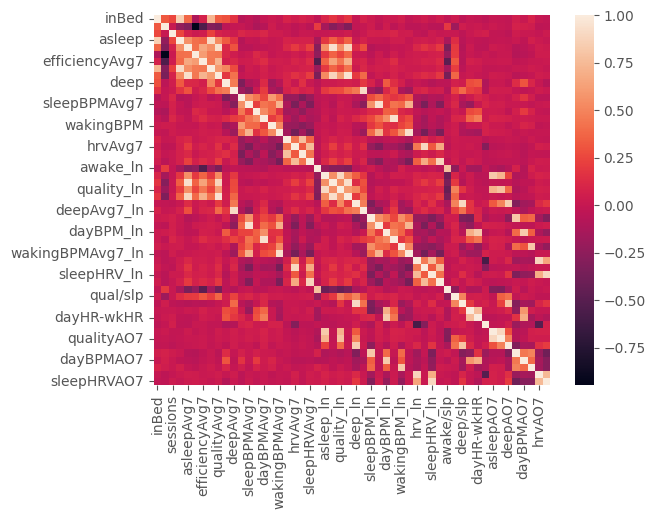

In [76]:
# Correlation Matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.show()

In [77]:
# Correlations
corr_matrix["asleep"].sort_values(ascending=False)

asleep              1.000000
quality             0.910807
inBed               0.851754
asleepAvg7          0.555865
qualityAvg7         0.527227
efficiency          0.409735
efficiencyAvg7      0.384620
qualityAvg7_ln      0.357216
asleepAvg7_ln       0.340832
deep                0.328045
sessions            0.251988
quality_ln          0.210159
asleep_ln           0.182628
deepAvg7            0.177416
qual/slp            0.136279
hrv                 0.085254
sleepHRV            0.078503
deepAvg7_ln         0.077111
sleepHRVAvg7        0.075711
sleepHRVAvg7_ln     0.071052
hrvAvg7             0.066678
wakingBPMAO7        0.060193
hrvAvg7_ln          0.050341
wakingBPM_ln        0.049559
dayBPMAvg7_ln       0.042494
hrv_ln              0.037214
sleepHRV_ln         0.030996
dayBPMAvg7          0.030540
hrvAO7              0.024114
sleepBPMAO7         0.015894
sleepBPM_ln         0.012850
wakingBPMAvg7       0.012821
sleepBPMAvg7_ln     0.006799
deep_ln             0.004734
wakingBPMAvg7_

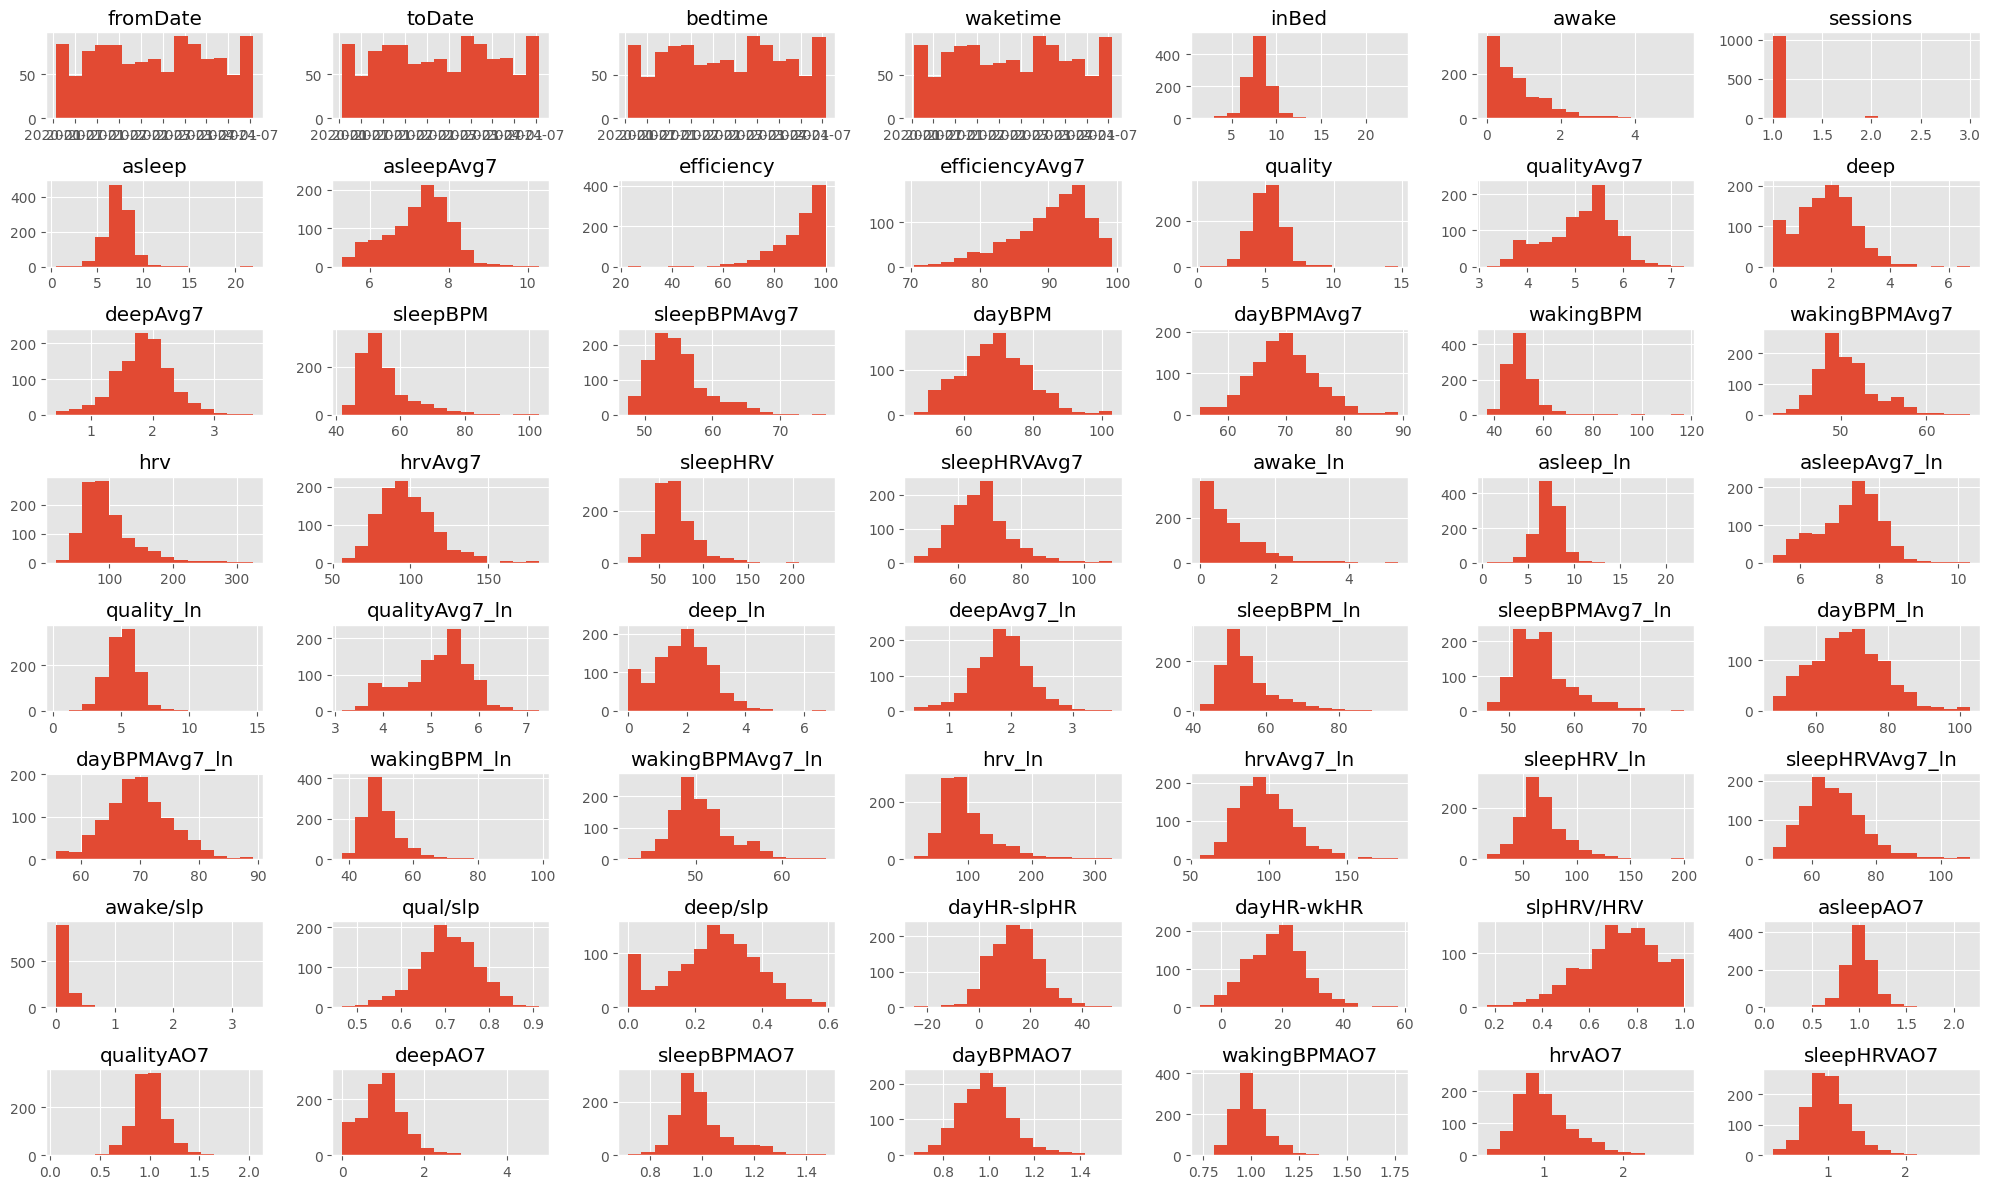

In [78]:
df.hist(bins=15, figsize=(20,12))
plt.tight_layout()
plt.show()

## Pre-Processing ##

In [79]:
df = df.reset_index().drop('fromDate',axis=1)
# df=df.dropna()
print(df.shape)
print(round(df.shape[0]*0.75))
# print(df.head())

(1074, 57)
806


In [80]:
X = df.drop('asleep', axis=1)
y = df['asleep']

Cutoff=860

X_train = X[X.index<Cutoff]
X_test = X[X.index>=Cutoff]
y_train = y[y.index<Cutoff]
y_test = y[y.index>=Cutoff]

print(len(X_train))
print(len(X_test))

860
214


### Standardization

In [81]:
#standardize the train and test sets
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.float64)),
    (cat_pipeline, make_column_selector(dtype_include=np.int64)))
X_train_processed = preprocessing.fit_transform(X_train)
X_test_processed = preprocessing.transform(X_test)

print(f'X_train_processed shape: {X_train_processed.shape}')
print(f'X_test_processed shape: {X_test_processed.shape}')

X_train_processed shape: (860, 913)
X_test_processed shape: (214, 913)


### Functions to get Results

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
    y_pred = model.predict(X_test_processed)
    # Calculate regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
    # Print the metrics with newline characters
    print("MAE: {:.2f}".format(mae))
    print("MSE: {:.2f}".format(mse))
    print("RMSE: {:.2f}".format(rmse))
    print("R^2 Score: {:.2f}".format(r2))
    print("OOS R^2 Score: {:.2f}".format(oosr2))
    return ''
    
def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:40], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Linear Reg

In [83]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_processed,y_train)
linreg_preds = linreg.predict(X_test_processed)

print(ResultsOut(linreg))

MAE: 0.01
MSE: 0.00
RMSE: 0.01
R^2 Score: 1.00
OOS R^2 Score: 1.00



## Ridge

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

Alpha = [10**4,10**3,10**2,10**1,10**0,10**-1,10**-2,10**-3]

# Scoring in sklearn is done by choosing the largest value
param_grid_ridge={'alpha':Alpha}

ridge = GridSearchCV(Ridge(),param_grid=param_grid_ridge,cv=5,n_jobs=-1)

ridge.fit(X_train_processed,y_train)
ridge_preds = ridge.predict(X_test_processed)

print(ridge.best_estimator_)
print(paramResults(ridge))
print(ResultsOut(ridge))

Ridge(alpha=0.001)
   alpha_param  Accuracy
0    10000.000  0.165583
1     1000.000  0.749028
2      100.000  0.967848
3       10.000  0.996146
4        1.000  0.999687
5        0.100  0.999885
6        0.010  0.999901
7        0.001  0.999902

MAE: 0.01
MSE: 0.00
RMSE: 0.01
R^2 Score: 1.00
OOS R^2 Score: 1.00



## Lasso

In [85]:
from sklearn.linear_model import Lasso

lasso = GridSearchCV(Lasso(max_iter=10000),param_grid=param_grid_ridge,cv=5,n_jobs=-1)

lasso.fit(X_train_processed,y_train)
lasso_preds = ridge.predict(X_test_processed)

print(lasso.best_estimator_)
print(paramResults(lasso))
print(ResultsOut(lasso))

Lasso(alpha=0.001, max_iter=10000)
   alpha_param  Accuracy
0    10000.000 -0.196658
1     1000.000 -0.196658
2      100.000 -0.196658
3       10.000 -0.196658
4        1.000  0.288412
5        0.100  0.970322
6        0.010  0.999687
7        0.001  0.999995

MAE: 0.00
MSE: 0.00
RMSE: 0.00
R^2 Score: 1.00
OOS R^2 Score: 1.00



## ElasticNet

In [86]:
from sklearn.linear_model import ElasticNet

param_grid_elastic = {'l1_ratio':[.25, .5, .75],'alpha':Alpha}

elasnet = GridSearchCV(ElasticNet(max_iter=10000),param_grid=param_grid_elastic,cv=5,n_jobs=-1)
elasnet.fit(X_train_processed,y_train)
elasnet.predict(X_test_processed)

print(elasnet.best_estimator_)
print(paramResults(elasnet))
print(ResultsOut(elasnet))

ElasticNet(alpha=0.001, l1_ratio=0.75, max_iter=10000)
    alpha_param  l1_ratio_param  Accuracy
0     10000.000            0.25 -0.196658
1     10000.000            0.50 -0.196658
2     10000.000            0.75 -0.196658
3      1000.000            0.25 -0.196658
4      1000.000            0.50 -0.196658
5      1000.000            0.75 -0.196658
6       100.000            0.25 -0.196658
7       100.000            0.50 -0.196658
8       100.000            0.75 -0.196658
9        10.000            0.25 -0.196658
10       10.000            0.50 -0.196658
11       10.000            0.75 -0.196658
12        1.000            0.25  0.728611
13        1.000            0.50  0.590088
14        1.000            0.75  0.463339
15        0.100            0.25  0.975198
16        0.100            0.50  0.974501
17        0.100            0.75  0.973043
18        0.010            0.25  0.998661
19        0.010            0.50  0.999116
20        0.010            0.75  0.999446
21        0.001      

## PCR

In [87]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline

pipe = Pipeline([("pca", PCA()),
                 ("ols", LinearRegression())])

param_grid = [{"pca__n_components" : range(1,X_train_processed.shape[1],int(np.ceil(X_train_processed.shape[1]/10)))}]

pcr = GridSearchCV(pipe, param_grid=param_grid, cv=5)
pcr.fit(X_train_processed, y_train)
pcr_preds = pcr.predict(X_test_processed)

print(pcr.best_estimator_)
print(paramResults(pcr))
print(ResultsOut(pcr))

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py", line 462, in fit_transform
    U, S, Vt = self._fit(X)
               ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py", line 480, in _fit
    raise TypeError(
TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.


## Random Forest

RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=95,
                      random_state=42069)
    max_depth_param  n_estimators_param  Accuracy
0                 3                  25  0.120783
1                 3                  35  0.108851
2                 3                  45  0.111221
3                 3                  55  0.113320
4                 3                  65  0.120512
5                 3                  75  0.113683
6                 3                  85  0.114398
7                 3                  95  0.118449
8                 5                  25  0.152972
9                 5                  35  0.161261
10                5                  45  0.166750
11                5                  55  0.169057
12                5                  65  0.170630
13                5                  75  0.167944
14                5                  85  0.166879
15                5                  95  0.172495
16                7                

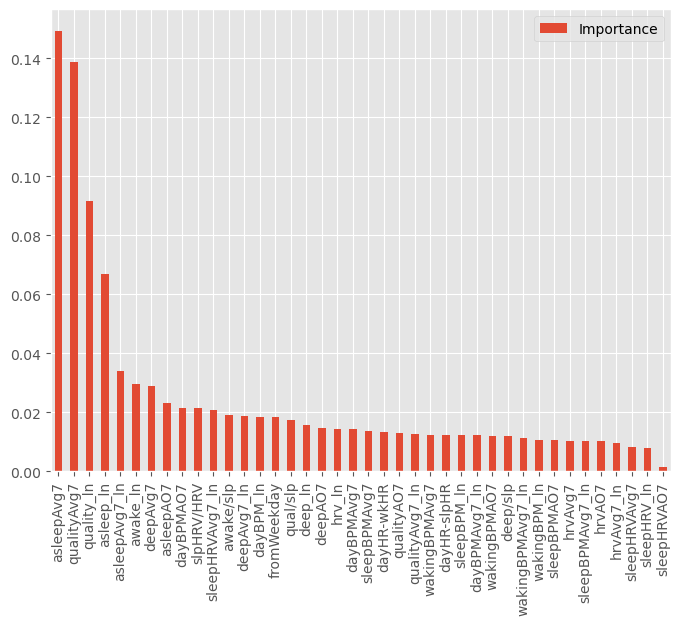

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {'n_estimators': range(25,100,10),'max_depth': range(3,9,2)}

rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42069,max_features='sqrt'), cv=5, param_grid=param_grid_rf,n_jobs=-1)
# rf = RandomForestRegressor(random_state=42069,max_features='sqrt', n_estimators=35, max_depth=5)
rf.fit(X_train_processed, y_train)

print(rf.best_estimator_)
print(paramResults(rf))
print(ResultsOut(rf))
featImport(rf)

## Gradient Boosed Trees

GradientBoostingRegressor(max_depth=2, n_estimators=380, random_state=42069,
                          subsample=1)
     learning_rate_param  max_depth_param  n_estimators_param  \
0                  0.100                1                 300   
1                  0.100                1                 300   
2                  0.100                1                 300   
3                  0.100                1                 310   
4                  0.100                1                 310   
..                   ...              ...                 ...   
235                0.001                2                 380   
236                0.001                2                 380   
237                0.001                2                 390   
238                0.001                2                 390   
239                0.001                2                 390   

     subsample_param  Accuracy  
0               0.50  0.277108  
1               0.75  0.307455  
2   

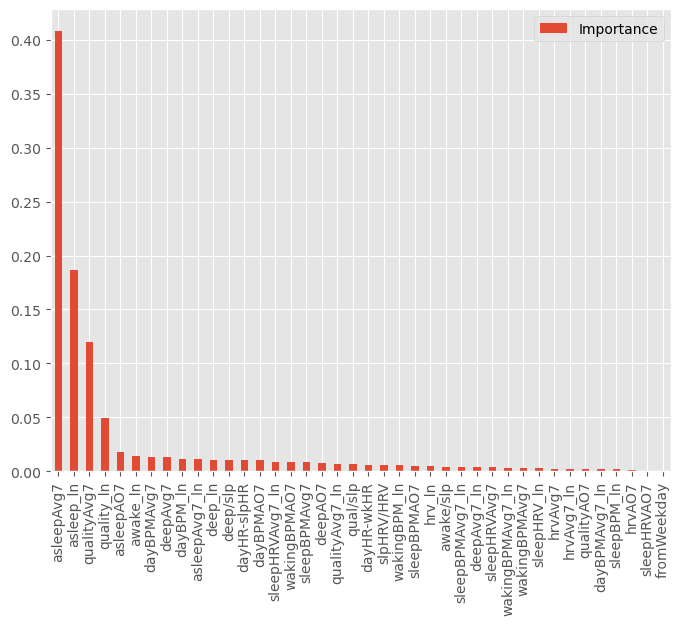

Runtime: 209.86s


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
start = time.perf_counter()

param_grid_gbrt = {'n_estimators': range(300,400,10),'learning_rate': [0.1,0.05,0.01,0.001],'max_depth': [1,2], 'subsample': [0.5,0.75,1]}

gbrt = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42069), cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
gbrt.fit(X_train_processed, y_train)
gbrt_preds = gbrt.predict(X_test_processed)

print(gbrt.best_estimator_)

print(paramResults(gbrt))
print(ResultsOut(gbrt))
featImport(gbrt)
print(f'Runtime: {round(time.perf_counter()-start,2)}s')

## XG Boost

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42069, ...)
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                1                 100             0.50   
1                  0.01                1                 100             0.75   
2                 

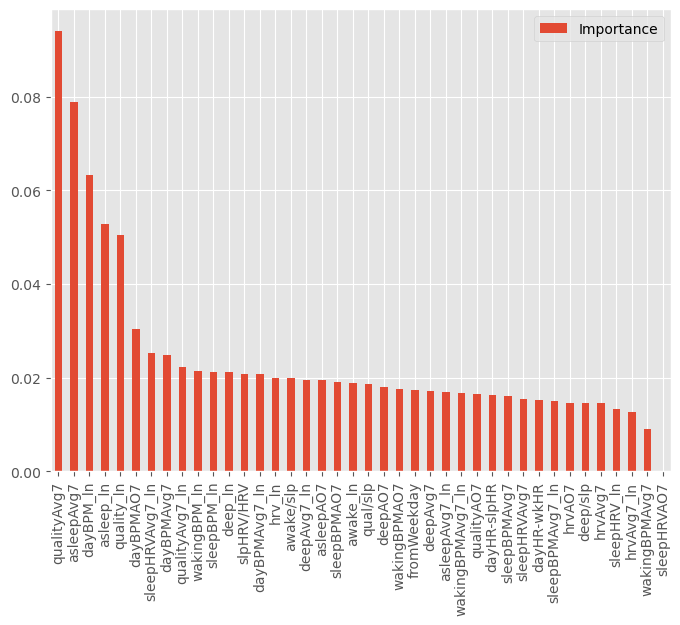

Runtime: 17.91s


In [ ]:
from xgboost import XGBRegressor
start = time.perf_counter()

param_grid_xgb = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.05,0.1],'max_depth': [1,2], 'subsample':[0.5,0.75,1]}

xgb = GridSearchCV(estimator=XGBRegressor(random_state=42069), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
xgb.fit(X_train_processed, y_train)
xgb_preds = xgb.predict(X_test_processed)

print(xgb.best_estimator_)
print(paramResults(xgb))
print(ResultsOut(xgb))
featImport(xgb)
print(f'Runtime: {round(time.perf_counter()-start,2)}s')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42069, ...)
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                1                 300              0.6   
1                  0.01                1                 300              0.8   
2                  

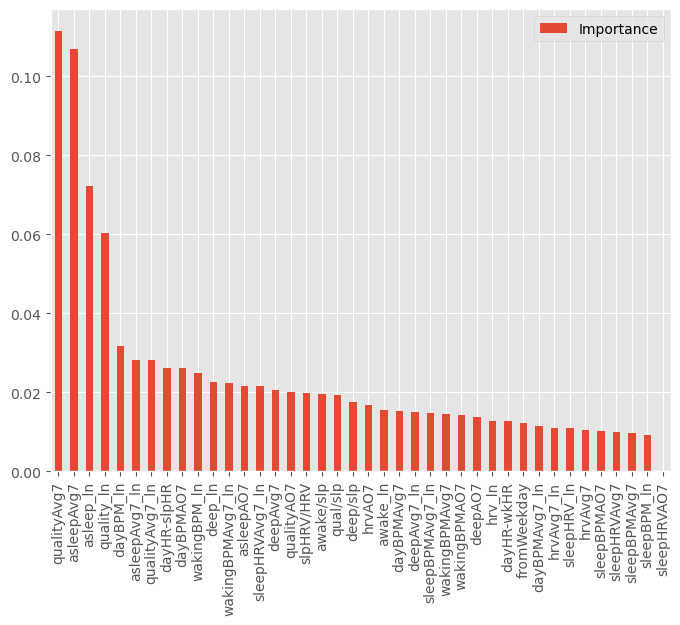

Runtime: 29.55s


In [ ]:
start = time.perf_counter()
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [1,2],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [300, 500, 700]
}
xgbn = GridSearchCV(estimator=XGBRegressor(random_state=42069), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
xgbn.fit(X_train_processed, y_train)
xgbn_preds = xgb.predict(X_test_processed)

print(xgbn.best_estimator_)
print(paramResults(xgbn))
print(ResultsOut(xgbn))
featImport(xgbn)
print(f'Runtime: {round(time.perf_counter()-start,2)}s')

In [ ]:
modelss = [linreg,ridge,lasso,elasnet,pcr,rf,gbrt,xgb,xgbn]
model_namess = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 'Principal Component Regression',
              'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'XGBoost2']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R-squared', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_processed)
        
        # Calculate regression metrics
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i], mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('OOS R2', ascending=False).reset_index(drop=True)
    
    return metrics_df

saveResults(modelss,model_namess)

,Model,MAE,MSE,RMSE,R-squared,OOS R2
0,Principal Component Regression,0.774,1.291,1.136,0.588,0.599
1,Lasso,0.767,1.295,1.138,0.587,0.598
2,Ridge,0.775,1.298,1.139,0.585,0.597
3,ElasticNet,0.768,1.304,1.142,0.584,0.595
4,Linear Regression,0.779,1.318,1.148,0.579,0.591
5,XGBoost2,0.899,1.824,1.351,0.418,0.434
6,XGBoost,0.879,1.848,1.359,0.410,0.427
7,Gradient Boosted Trees,0.967,2.011,1.418,0.358,0.376
8,Random Forest,1.021,2.441,1.562,0.221,0.242


In [ ]:
print(f'Final Runtime: {round(time.perf_counter()-int_start,2)}s')

Final Runtime: 269.17s
